# Time Series Analysis and Forecasting Using ARMAX

classic time series analysis tool:
- trend analysis (time-dependent)
- seasonal analysis (time-dependent)
- cyclical analysis (series-dependent)
- irregular analysis (random)

some tests
- stationary tests
    - ADF 
    - KPSS
- c 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

sns.set_style('darkgrid')

data_file = './data/model_ready.parquet'
df = pd.read_parquet(data_file, "pyarrow")

# sort index
df = df.sort_index()
# the frequency of the datatime index is not set. based on inspection, it is sampled hourly. here i will set the frequency to 1 hour in case in the future i may need to resample the data.
df = df.asfreq('H')

# separte names for inspection
columns = df.columns
load_names = []
wind_names = []
dewpoint_names = []
target_names = []
for col in columns:
    if 'mtlf' in col:
        load_names.append(col)
    if 'ws' in col:
        wind_names.append(col)
    if 'td' in col:
        dewpoint_names.append(col)
    if 'da_energy' in col:
        target_names.append(col)


## Stationary Test
Two statistical tests would be used to check the stationarity of a time series – Augmented Dickey Fuller (“ADF”) test and Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test. A method to convert a non-stationary time series into stationary series shall also be used.

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:
- Case 1: Both tests conclude that the series is not stationary - The series is not stationary
- Case 2: Both tests conclude that the series is stationary - The series is stationary
- Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.
- Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.


In [19]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

<Figure size 640x480 with 0 Axes>

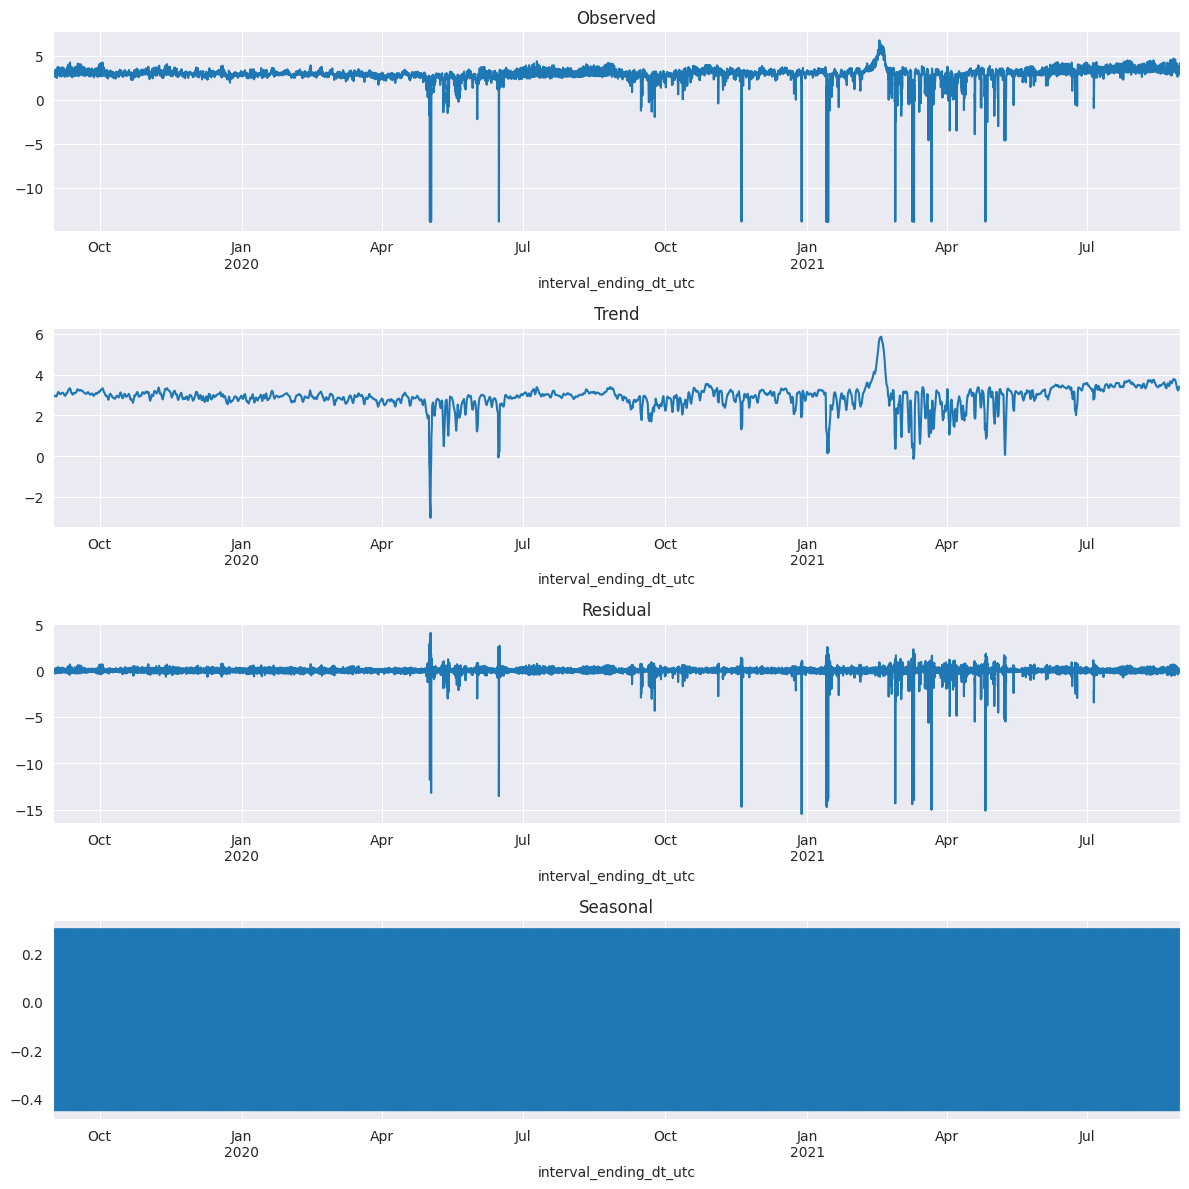

<Figure size 640x480 with 0 Axes>

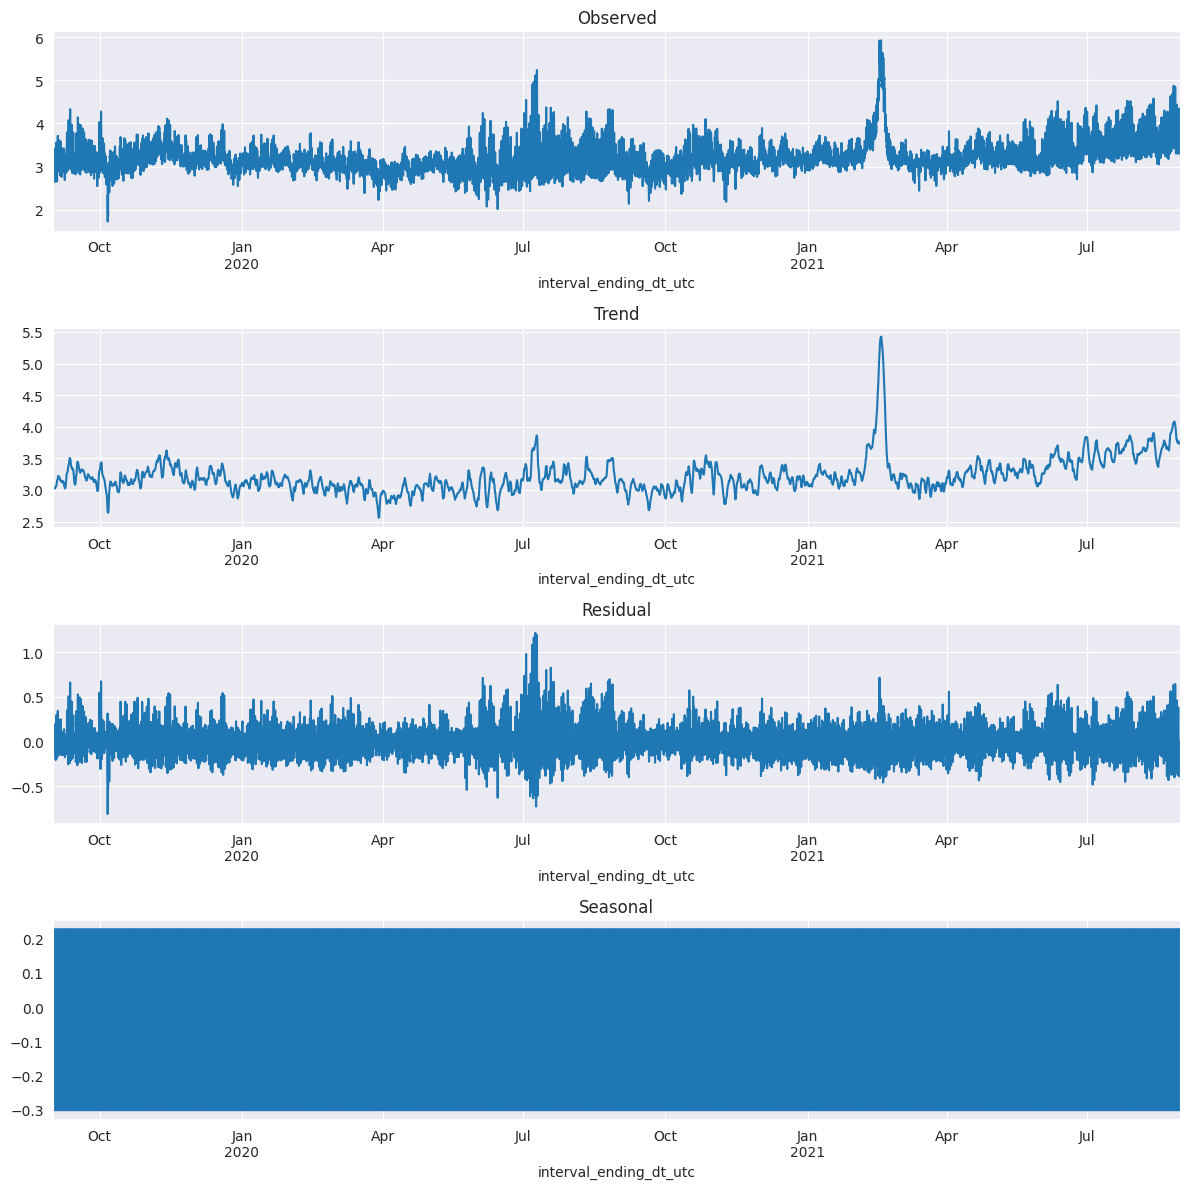

<Figure size 640x480 with 0 Axes>

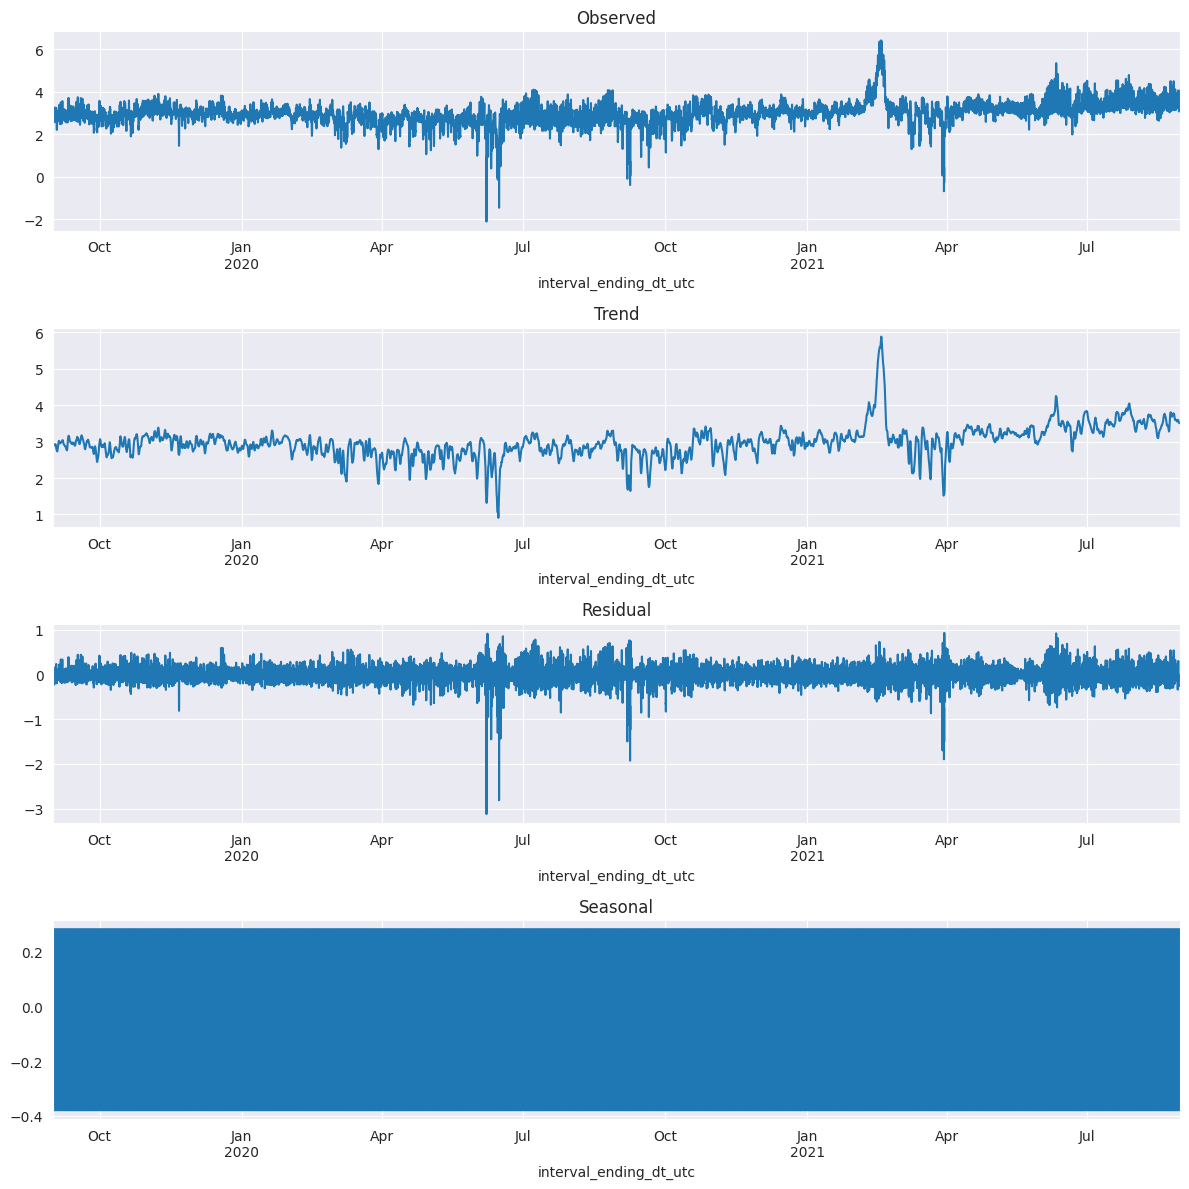

In [7]:
# Decompose the log electricity price time-series
for i, target in enumerate(target_names):
    res = sm.tsa.seasonal_decompose(np.log(df[target].abs()+1e-06), model='additive')
    plt.figure(i)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12))
    res.observed.plot(ax=ax1, title='Observed')
    res.trend.plot(ax=ax2, title='Trend')
    res.resid.plot(ax=ax3, title='Residual')
    res.seasonal.plot(ax=ax4, title='Seasonal')
    plt.tight_layout()
    plt.show()

ADF test determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

If the test statistics is smaller than the critical value, we can reject the null hypothesis in favor of the alternative hypothesis.


In [20]:
for target in target_names:
    y = df[target]
    adftest = adf_test(y)


Results of Dickey-Fuller Test:
Test Statistic                -9.442901e+00
p-value                        4.841013e-16
#Lags Used                     4.300000e+01
Number of Observations Used    1.745300e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+00
Critical Value (10%)          -2.566858e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.099454e+01
p-value                        6.924249e-20
#Lags Used                     4.300000e+01
Number of Observations Used    1.745300e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+00
Critical Value (10%)          -2.566858e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -9.517134e+00
p-value                        3.135187e-16
#Lags Used                     4.400000e+01
Number of Observations Used    1.745200e+04
Critical Value (1%)           -3.430725e+00
Critical Value (5%)           -2.861706e+

The ADF statistic for all three targets are around -9.5, which is less than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

- Null Hypothesis: The process is trend stationary.
- Alternate Hypothesis: The series has a unit root (series is not stationary).

If the test statistics is smaller than the critical value, we can reject the null hypothesis in favor of the alternative hypothesis.

In [21]:
for target in target_names:
    y = df[target]
    kpsstest = kpss_test(y)

Results of KPSS Test:
Test Statistic            0.942328
p-value                   0.010000
Lags Used                74.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test:
Test Statistic            2.494684
p-value                   0.010000
Lags Used                72.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of KPSS Test:
Test Statistic            2.437902
p-value                   0.010000
Lags Used                74.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/tmp/ipykernel_56922/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/tmp/ipykernel_56922/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")
/tmp/ipykernel_56922/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


KPSS statistics is greater than the critical value at 1% (0.739) and thus **we fail to reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is a root-unit in the time series and thus, that it is not stationary.



In summary, KPSS indicates a non-stationary series (i.e. there is a unit root) whereas ADF indicates a stationary series. This is a contradiction. The reason for this contradiction is that the KPSS test has low power in the presence of a trend. In other words, when the series is trend stationary, the KPSS test incorrectly fails to reject the null hypothesis about 33% of the time. Thus, we can conclude that the series is trend stationary.

To remove the trend, we can take the first difference of the series and then apply the ADF test again. 


<Axes: xlabel='interval_ending_dt_utc'>

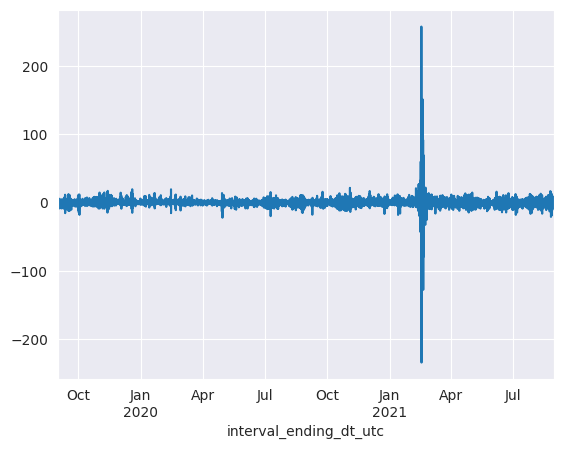

In [15]:
df_cp = df.copy()
target = target_names[0]
df_cp['diff'] = df_cp[target] - df_cp[target].shift(1)

df_cp['diff'].dropna().plot()

In [22]:
adf_test(df_cp['diff'].dropna())

Results of Dickey-Fuller Test:
Test Statistic                   -19.776462
p-value                            0.000000
#Lags Used                        41.000000
Number of Observations Used    17454.000000
Critical Value (1%)               -3.430725
Critical Value (5%)               -2.861706
Critical Value (10%)              -2.566858
dtype: float64


The ADF test shows that the statistics is smaller than the critical value at 1% (-3.431) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

In [23]:
kpss_test(df_cp['diff'].dropna())

Results of KPSS Test:
Test Statistic             0.02051
p-value                    0.10000
Lags Used                584.00000
Critical Value (10%)       0.34700
Critical Value (5%)        0.46300
Critical Value (2.5%)      0.57400
Critical Value (1%)        0.73900
dtype: float64


/tmp/ipykernel_56922/2591240010.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


Now the KPSS test shows that the test statistics is smaller than the critical value at 1% (0.739) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is stationary.

## Autocorrelation and Partial Autocorrelation